# Project: Identify Customer Segments

In this project we will try to identify segments in population that have more chance to be a client to our company, so we will focus our next communication campaign on these people.

We have have two databases: characteristics of general population and of our customers. We will cluster the general population, and see to which clusters our customers fit.

## Table of Contents

1. [Preliminary Wrangling](#Preliminary_Wrangling)<br>
1.a.-[Gathering Data](#Gathering_Data)<br>
1.b.-[Assesing and Cleaning Data](#Assesing_cleaning_data)<br>
1.c.-[Consolidation of Dataframes](#Consolidaion_dataframes)<br>
2. [Featuring reduction](#Feat_read)<br>
3. [Clustering](#Clustering)<br>

## <a class="anchor" id="Preliminary_Wrangling">Part 1: Preliminary Wrangling

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time

%matplotlib inline



### <a class="anchor" id="Gathering_Data"> 1.a.- Gathering Data

In this section we´ll gather data from both files available. There are four data files associated with this project :

- `AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood.

In [9]:
# Load in the general demographics data.
azdias = pd.read_csv('AZDIAS_Subset.csv',sep=';')
customers = pd.read_csv('CUSTOMERS_Subset.csv',sep = ';')
features = pd.read_csv('AZDIAS_Feature_Summary.csv',sep = ';')

In [10]:
# We get the size of the datasets
print("The shape of AZDIAS dataset is:",azdias.shape)
print("The shape of Customers dataset is:",customers.shape)
print("The shape of Features dataset is:",features.shape)

The shape of AZDIAS dataset is: (891221, 85)
The shape of Customers dataset is: (191652, 85)
The shape of Features dataset is: (85, 4)


In [11]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [13]:
features.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [14]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               191652 non-null  int64  
 1   ALTERSKATEGORIE_GROB   191652 non-null  int64  
 2   ANREDE_KZ              191652 non-null  int64  
 3   CJT_GESAMTTYP          188439 non-null  float64
 4   FINANZ_MINIMALIST      191652 non-null  int64  
 5   FINANZ_SPARER          191652 non-null  int64  
 6   FINANZ_VORSORGER       191652 non-null  int64  
 7   FINANZ_ANLEGER         191652 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 9   FINANZ_HAUSBAUER       191652 non-null  int64  
 10  FINANZTYP              191652 non-null  int64  
 11  GEBURTSJAHR            191652 non-null  int64  
 12  GFK_URLAUBERTYP        188439 non-null  float64
 13  GREEN_AVANTGARDE       191652 non-null  int64  
 14  HEALTH_TYP             191652 non-nu

In [15]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [16]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


### <a class="anchor" id="Assesing_cleaning_data"> 1.b.- Asessing and cleaning data
    
#### Assessing Missing Data

The feature summary file contains a summary of properties for each demographics data column. The fourth columns tells the values that mean "missing or unknown", that we must replace with NaNs.


In [17]:
#First we create copies of the original dataframes
cust_clean = customers.copy()
feat_clean = features.copy()
az_clean = azdias.copy()

In [18]:
#We divide the features in numeric and non numeric
numeric = ['GEBURTSJAHR','ANZ_PERSONEN','ANZ_TITEL','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','MIN_GEBAEUDEJAHR','KBA13_ANZAHL_PKW']
char = np.setdiff1d(azdias.columns,numeric)

In [19]:
# We create a dictionary with the values that must be NaN for each column
feat_dic = {}
for i in range(0, len(feat_clean)):
# for i in range(5):
    feat = feat_clean.attribute[i]
    list1 = feat_clean.missing_or_unknown[i][1:-1].split(",")
#     print(features.attribute[i])
    if list1 != ['']:
        if feat_clean.attribute[i] in numeric:
            list1_mod = [int(i) for i in list1] 
            feat_dic[feat_clean.attribute[i]] = list1_mod
        elif az_clean[feat].dtype=='float64':
            for i in range(len(list1)):
                list1[i] = list1[i]+'.0'

            feat_dic[feat] = list1
        else:
            feat_dic[feat_clean.attribute[i]] = list1

In [20]:
# We convert the non numeric strings to columns
columns = az_clean.columns
for i in range(len(az_clean.columns)):
    feat =  columns[i]
    if feat in char:
        az_clean[feat] = az_clean[feat].astype(str)


In [21]:
#We overwrite with Nans the values considered as "missing or unknown"
for i in range(len(feat_dic)):
    feat =[*feat_dic.keys()][i]
    az_clean[feat] = az_clean[feat].replace('nan',np.nan)
    feat_vals = feat_dic[feat]
    for j in range(len(feat_vals)):
        val = feat_dic[feat][j]
        az_clean[feat] = az_clean[feat].replace(val,np.nan)


#### Cleaning Missing Data per columns

In [22]:
# Here we can see the rate of null values in each column
pd.set_option('display.max_rows', None)
rate_nulls = az_clean.isnull().sum()/len(az_clean)
rate_nulls = pd.DataFrame(data=rate_nulls).reset_index()
rate_nulls.columns = ['feature', 'rate_nulls']
rate_nulls.sort_values(by = 'rate_nulls', ascending = False)


,feature,rate_nulls
40,TITEL_KZ,0.997576
0,AGER_TYP,0.769554
47,KK_KUNDENTYP,0.655967
64,KBA05_BAUMAX,0.534687
11,GEBURTSJAHR,0.440203
43,ALTER_HH,0.348137
70,KKK,0.177357
73,REGIOTYP,0.177357
48,W_KEIT_KIND_HH,0.166051
60,KBA05_ANTG1,0.149597


In [23]:
pd.set_option('display.max_rows', 30)

We´ve decided to remove the columns that have more than 10% of null values. In the prior dataframe, those with rate_nulls > 0.1

In [24]:
end_cols = rate_nulls[rate_nulls.rate_nulls<0.10].feature.to_list()
drop_cols = rate_nulls[rate_nulls.rate_nulls>0.10].feature.to_list()
len(end_cols), len(drop_cols)

(41, 44)

In [25]:
drop_cols

['AGER_TYP',
 'GEBURTSJAHR',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'SHOPPER_TYP',
 'TITEL_KZ',
 'VERS_TYP',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'W_KEIT_KIND_HH',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'KKK',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB']

We drop columns with more than 10% of null values

In [26]:
az_clean = az_clean[end_cols]

In [27]:
az_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,SOHO_KZ,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,KONSUMNAEHE,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET
0,2,1,2.0,3,4,3,5,5,3,4,...,NaN,3,NaN,NaN,2.0,NaN,nan,nan,nan,1.0
1,1,2,5.0,1,5,2,5,4,5,1,...,1.0,5,2.0,0.0,6.0,9.0,1.0,3.0,1.0,3.0
2,3,2,3.0,1,4,1,2,3,5,1,...,0.0,5,1.0,0.0,4.0,9.0,5.0,4.0,3.0,2.0
3,4,2,2.0,4,2,5,2,1,2,6,...,0.0,3,0.0,0.0,1.0,9.0,4.0,4.0,4.0,1.0
4,3,1,5.0,4,3,4,1,3,2,5,...,0.0,4,4.0,0.0,5.0,9.0,4.0,5.0,3.0,5.0


There are a lot of missing values in this dataframe. Analyzing the percentage of null values we´ve decided to leave only the columns that have less than 10% of null values. We think it is a rate that can be accepted

There were 44 columns deleted (out of 85). Most of the columns deleted (44) where non personal level features. At the end we remain with the next number of features per cathegory:

- Personal level features: 33 out of 43 in the begining
- Household level features: 4 out of 7 in the begining
- Building level features: 1 out of 7 in the begining
- RR4 micro-cell features: 0 out of 3 in the begining
- RR3 micro-cell features: 0 out of 6 in the begining
- Postcode-level features: 0 out of 3 in the begining
- RR1 region features: 3 out of 5 in the begining
- PLZ8 macro-cell features: 0 out of 8 in the begining
- Community-level features: 0 out of 3 in the begining

#### Cleaning Missing Data per rows

Now we´ll do something similar, but looking to NaN values by rows, instead of columns. 

In [35]:
az_clean.isnull().sum(axis = 1).value_counts().sort_values()/len(az_clean)

3    0.000110
7    0.000129
1    0.023426
2    0.030667
4    0.031329
6    0.056458
0    0.857880
dtype: float64

We take as outlier those rows with more than 5 null values, so I´m going to delete them

In [36]:
az_clean_not5 = az_clean[az_clean.isnull().sum(axis = 1)>5]
az_clean_5 = az_clean[az_clean.isnull().sum(axis = 1)<=5]
len(az_clean_not5), len(az_clean_5),len(azdias)

(50432, 840789, 891221)

We´ve divided the rows between the ones that have more or less than 5 null values. Rows with less or equal to 5 null values are 840.789 out of 891221, 94% of total

#### Create dummy features

For categorical data, we need to encode the levels as dummy variables.

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
az_clean_5 = pd.get_dummies(az_clean_5)

In [38]:
az_clean_5.head()

,ANZ_PERSONEN,ANZ_TITEL,ALTERSKATEGORIE_GROB_1,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,...,MOBI_REGIO_4.0,MOBI_REGIO_5.0,MOBI_REGIO_6.0,MOBI_REGIO_nan,ONLINE_AFFINITAET_0.0,ONLINE_AFFINITAET_1.0,ONLINE_AFFINITAET_2.0,ONLINE_AFFINITAET_3.0,ONLINE_AFFINITAET_4.0,ONLINE_AFFINITAET_5.0
0,NaN,NaN,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,2.0,0.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,0.0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0.0,0,0,0,1,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
4,4.0,0.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


All the categorical values have been reencoded to dummies. Now there are only 2 numerical columns

#### Create and apply cleaning function

In [39]:
#First we create copies of the original dataframes
cust_clean = customers.copy()
feat_clean = features.copy()
az_clean = azdias.copy()

We create a cleaning function with the steps done before, so we can apply it to azdias and custoemers databases

In [40]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    numeric = ['GEBURTSJAHR','ANZ_PERSONEN','ANZ_TITEL','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','MIN_GEBAEUDEJAHR','KBA13_ANZAHL_PKW']
    char = np.setdiff1d(azdias.columns,numeric)

    # We create a dictionary with the values that must be NaN for each column
    feat_dic = {}
    for i in range(0, len(feat_clean)):
        feat = feat_clean.attribute[i]
        list1 = feat_clean.missing_or_unknown[i][1:-1].split(",")
        if list1 != ['']:
            if feat_clean.attribute[i] in numeric:
                list1_mod = [int(i) for i in list1] 
                feat_dic[feat_clean.attribute[i]] = list1_mod
            elif df[feat].dtype=='float64':
                for i in range(len(list1)):
                    list1[i] = list1[i]+'.0'

                feat_dic[feat] = list1
            else:
                feat_dic[feat_clean.attribute[i]] = list1

    # We convert the non numeric strings to columns
    columns = df.columns
    for i in range(len(df.columns)):
        feat =  columns[i]
        if feat in char:
            df[feat] = df[feat].astype(str)


    #We overwrite with Nans
    for i in range(len(feat_dic)):
        feat =[*feat_dic.keys()][i]
        df[feat] = df[feat].replace('nan',np.nan)
        feat_vals = feat_dic[feat]
        for j in range(len(feat_vals)):
            val = feat_dic[feat][j]
            df[feat] = df[feat].replace(val,np.nan)
    return df



We apply the cleaning function that fills the dataframe with NaN´s needed to both dataframes

In [41]:
az_clean = clean_data(az_clean)
cust_clean = clean_data(cust_clean)

We obtain the columns to drop, according to the threshold set before

In [42]:
rate_nulls = az_clean.isnull().sum()/len(az_clean)
rate_nulls = pd.DataFrame(data=rate_nulls).reset_index()
rate_nulls.columns = ['feature', 'rate_nulls']

end_cols = rate_nulls[rate_nulls.rate_nulls<0.10].feature.to_list()

We create and apply a function to delete outliers columns and rows and to create dummies out of the categorical columns

In [43]:
def clean_data_2(df):
    df = df[end_cols]
    df = df[df.isnull().sum(axis = 1)<=5]
    df = pd.get_dummies(df)
    return df

In [44]:
az_clean = clean_data_2(az_clean)
cust_clean = clean_data_2(cust_clean)

In [45]:
print("The initial shape of general database was",azdias.shape )
print("The shape of the cleaned general database is",az_clean.shape )
print("The initial shape of customers database was",customers.shape )
print("The shape of the cleaned customers database is",cust_clean.shape )

The initial shape of general database was (891221, 85)
The shape of the cleaned general database is (840789, 248)
The initial shape of customers database was (191652, 85)
The shape of the cleaned customers database is (147475, 248)


#### Replacing null values
There are still null values in both datasets

In [46]:
az_clean.isnull().sum().sort_values()

SEMIO_MAT_3                0
SEMIO_RAT_2                0
SEMIO_RAT_3                0
SEMIO_RAT_4                0
SEMIO_RAT_5                0
                       ...  
LP_STATUS_FEIN_9.0         0
LP_STATUS_GROB_1.0         0
LP_FAMILIE_GROB_3.0        0
ANZ_TITEL              27921
ANZ_PERSONEN           27921
Length: 248, dtype: int64

In [47]:
cust_clean.isnull().sum().sort_values()

SEMIO_MAT_3               0
SEMIO_RAT_2               0
SEMIO_RAT_3               0
SEMIO_RAT_4               0
SEMIO_RAT_5               0
                       ... 
LP_STATUS_FEIN_9.0        0
LP_STATUS_GROB_1.0        0
LP_FAMILIE_GROB_3.0       0
ANZ_TITEL              5632
ANZ_PERSONEN           5632
Length: 248, dtype: int64

In both databases there are only null values in the fields "ANZ_TITEL" and "ANZ_PERSONEN": Number of professional academic title holders in household and Number of adults in household. They are numerics so we are going to replace them with the mean value

In [48]:
az_clean.ANZ_TITEL = az_clean.ANZ_TITEL.fillna(az_clean.ANZ_TITEL.mean())
az_clean.ANZ_PERSONEN = az_clean.ANZ_PERSONEN.fillna(az_clean.ANZ_TITEL.mean())
cust_clean.ANZ_TITEL = cust_clean.ANZ_TITEL.fillna(cust_clean.ANZ_TITEL.mean())
cust_clean.ANZ_PERSONEN = cust_clean.ANZ_PERSONEN.fillna(cust_clean.ANZ_TITEL.mean())

In [49]:
az_clean.isnull().sum().sort_values()

ANZ_PERSONEN             0
SEMIO_RAT_2              0
SEMIO_RAT_3              0
SEMIO_RAT_4              0
SEMIO_RAT_5              0
                        ..
LP_STATUS_FEIN_8.0       0
LP_STATUS_FEIN_9.0       0
LP_STATUS_GROB_1.0       0
LP_FAMILIE_GROB_3.0      0
ONLINE_AFFINITAET_5.0    0
Length: 248, dtype: int64

In [50]:
cust_clean.isnull().sum().sort_values()

ANZ_PERSONEN             0
SEMIO_RAT_2              0
SEMIO_RAT_3              0
SEMIO_RAT_4              0
SEMIO_RAT_5              0
                        ..
LP_STATUS_FEIN_8.0       0
LP_STATUS_FEIN_9.0       0
LP_STATUS_GROB_1.0       0
LP_FAMILIE_GROB_3.0      0
ONLINE_AFFINITAET_5.0    0
Length: 248, dtype: int64

#### Reducing skewness in columns

Analyzing skew of both dataframes numeric columns we can see that only ANZ_TITEL has high skewness, so we are going to apply the logarithmic transformation to this feature, so we can reduce the skewness

In [68]:
numeric = ['ANZ_TITEL','ANZ_PERSONEN']
az_clean[numeric].skew()

ANZ_TITEL       19.168553
ANZ_PERSONEN     1.759486
dtype: float64

In [69]:
cust_clean[numeric].skew()

ANZ_TITEL       8.484747
ANZ_PERSONEN    0.868245
dtype: float64

In [70]:
az_clean.ANZ_TITEL = az_clean.ANZ_TITEL.apply(lambda x: np.log(x + 1))
cust_clean.ANZ_TITEL = cust_clean.ANZ_TITEL.apply(lambda x: np.log(x + 1))

#### Applying scaling to numerical features

We apply minmaxscaler to "ANZ_TITEL" and "ANZ_PERSONEN" columns that are the only numerical. The rest are numerical but dummy variables, so values are already between 0 and 1

In [71]:
scaler = MinMaxScaler() # default=(0, 1)
az_clean[numeric] = scaler.fit_transform(az_clean[numeric])
cust_clean[numeric] = scaler.fit_transform(cust_clean[numeric])

### <a class="anchor" id="Consolidaion_dataframes"> 1.c.- Consolidation of dataframes

In this section we´re going to consolidate both dataframes into files, that we´ll read for the next sections.

In [165]:
az_clean.to_csv('AZDIAS_cleaned.csv', index = False)
cust_clean.to_csv('Customers_clean.csv', index = False)

## <a class="anchor" id="Feat_read">Part 2: Featuring reduction

First, we read both dataframes from files

In [2]:
az = pd.read_csv('AZDIAS_cleaned.csv')
cust = pd.read_csv('Customers_clean.csv')

In [3]:
az.head()

,ANZ_PERSONEN,ANZ_TITEL,ALTERSKATEGORIE_GROB_1,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,...,MOBI_REGIO_4.0,MOBI_REGIO_5.0,MOBI_REGIO_6.0,MOBI_REGIO_nan,ONLINE_AFFINITAET_0.0,ONLINE_AFFINITAET_1.0,ONLINE_AFFINITAET_2.0,ONLINE_AFFINITAET_3.0,ONLINE_AFFINITAET_4.0,ONLINE_AFFINITAET_5.0
0,0.000092,0.00212,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,0.044444,0.00000,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.022222,0.00000,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.000000,0.00000,0,0,0,1,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0.088889,0.00000,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
cust.head()

,ANZ_PERSONEN,ANZ_TITEL,ALTERSKATEGORIE_GROB_1,ALTERSKATEGORIE_GROB_2,ALTERSKATEGORIE_GROB_3,ALTERSKATEGORIE_GROB_4,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,...,MOBI_REGIO_4.0,MOBI_REGIO_5.0,MOBI_REGIO_6.0,MOBI_REGIO_nan,ONLINE_AFFINITAET_0.0,ONLINE_AFFINITAET_1.0,ONLINE_AFFINITAET_2.0,ONLINE_AFFINITAET_3.0,ONLINE_AFFINITAET_4.0,ONLINE_AFFINITAET_5.0
0,0.095238,0.0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0.047619,0.0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,0.000000,0.0,0,0,0,1,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
3,0.190476,0.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.095238,0.0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Applying PCA

In this section we will apply feature reduction with PCA to the dataset with default values, without fixin the number of components

In [5]:
# Apply PCA to the data.
pca = PCA()
az_pca = pca.fit_transform(az)

In [6]:
column_names = ["Component", "variance", "acumulative_variance"]
variances = pd.DataFrame(columns = column_names)
var_acu = 0
for i in range(len(pca.explained_variance_ratio_)):
    comp = i +1 
    var = pca.explained_variance_ratio_[i]
    var_acu = var_acu +  var
    variances.loc[i] = [comp, var, var_acu]


Now we plot the acumulative and individual variance ratio versus the number oc principal components used

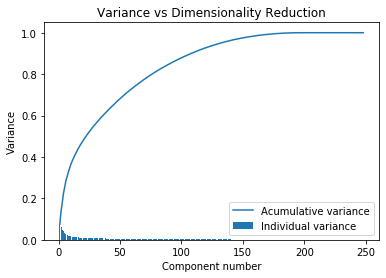

In [7]:
plt.plot(variances.Component, variances.acumulative_variance);
plt.bar(variances.Component, variances.variance);
plt.xlabel('Component number') 
plt.ylabel('Variance');
plt.legend(['Acumulative variance','Individual variance']);
plt.title('Variance vs Dimensionality Reduction');

In [8]:
variances.head()

,Component,variance,acumulative_variance
0,1.0,0.075305,0.075305
1,2.0,0.059760,0.135065
2,3.0,0.046103,0.181168
3,4.0,0.042342,0.223509
4,5.0,0.032534,0.256043


We can see that up from 150 components reduction the relative gain is very little.
As this is not a really big dataframe, with no high time consumption requisites, we´ve decided to keep the 95% of the variability in the original data, so we are going to reduce the dataframe to 131 dimensions

In [9]:
for i in range(len(variances)):
    if variances.acumulative_variance[i] > 0.95:
        num = i
        var = variances.acumulative_variance[i]
        break
        
print("Using", i, "variables, we can explain", round(var,2), "of the variability in the original data.")

Using 131 variables, we can explain 0.95 of the variability in the original data.


In [10]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 131)
az_pca = pca.fit_transform(az)


#### Interpreting Principal Components

Now that we have our transformed principal components, we are going to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

In [96]:
def pc_indexes(df, pca, n):
    """
    Gives the 10 most important variables with its weights in the component n after applying pca to de dataframe df
    
    INPUT: df (dataframe), pca (transformation applied), n(principal component to analyze)
    OUTPUT: list of the top 10 variables and their weights
    """

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
    components.index = dimensions
    df_comp = components.iloc[n-1].to_frame()
    df_comp["Abs_value"] = df_comp.abs()
    df_comp = df_comp.sort_values(by='Abs_value', ascending = False)
    df_comp = df_comp[df_comp.columns[0]].head(10)
    return df_comp


In [99]:
# Get weights for the first principal component
pc_indexes(az, pca, 1)

FINANZ_SPARER_1            0.2040
FINANZ_VORSORGER_5         0.1955
ALTERSKATEGORIE_GROB_4     0.1932
FINANZTYP_1               -0.1786
FINANZ_ANLEGER_1           0.1694
FINANZ_ANLEGER_5          -0.1587
FINANZ_MINIMALIST_1       -0.1446
SEMIO_REL_7               -0.1415
FINANZ_SPARER_5           -0.1381
FINANZ_UNAUFFAELLIGER_1    0.1373
Name: Dimension 1, dtype: float64

In [100]:
# Get weights for the second principal component
pc_indexes(az, pca, 2)

ANREDE_KZ_1     -0.3253
ANREDE_KZ_2      0.3253
SEMIO_ERL_4     -0.1722
SEMIO_TRADV_3    0.1669
SEMIO_VERT_2     0.1614
ZABEOTYP_3       0.1609
SEMIO_KAEM_3    -0.1559
SEMIO_REL_4     -0.1513
SEMIO_KULT_1     0.1428
SEMIO_ERL_7      0.1416
Name: Dimension 2, dtype: float64

In [101]:
# Get weights for the third principal component
pc_indexes(az, pca, 3)

ALTERSKATEGORIE_GROB_3   -0.3061
ALTERSKATEGORIE_GROB_4    0.2054
SEMIO_ERL_6              -0.1727
SEMIO_VERT_6              0.1566
FINANZ_VORSORGER_4       -0.1509
FINANZ_HAUSBAUER_5        0.1502
FINANZ_VORSORGER_5        0.1498
FINANZ_SPARER_1           0.1493
SEMIO_REL_4              -0.1469
FINANZ_HAUSBAUER_1       -0.1411
Name: Dimension 3, dtype: float64

The first principal component is calculated most from the financial personal features of the person

The second principal component is calculated from the type of person (gender, personality,..)

The third principal component is a mixed of personality and financial status of the person

## <a class="anchor" id="Clustering">Part 3: Clustering

#### Clustering general database
    
In this section we apply k-means clustering to the azdias database and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.
    
First we check the results with 5 and 8 clusters, and then we create a function and try with different number of clusters

In [111]:
start_time = time.time()

kmeans = KMeans(n_clusters=5)

model = kmeans.fit(az_pca)

score = np.abs(model.score(az_pca))

exec_time = round((time.time() - start_time)/60,2)
print("Execution time:",exec_time,"minutes")
print("The score for 5 components is", score)


Execution time: 1.18 minutes
The score for 5 components is 19027095.222822685


In [112]:
start_time = time.time()

kmeans = KMeans(n_clusters=8)

model = kmeans.fit(az_pca)

score = np.abs(model.score(az_pca))

exec_time = round((time.time() - start_time)/60,2)
print("Execution time:",exec_time,"minutes")
print("The score for 5 components is", score)
    

Execution time: 1.87 minutes
The score for 5 components is 17525732.983405728


In [115]:
def get_score(data, clusters):
    start_time = time.time()

    kmeans = KMeans(n_clusters= clusters)

    model = kmeans.fit(data)

    score = np.abs(model.score(data))

    exec_time = round((time.time() - start_time)/60,2)
    print("Execution time:",exec_time,"minutes")
    print("The score for",clusters,"components is", score)
    return score

get_score(az_pca, 5)

Execution time: 1.33 minutes
The score for 5 components is 19046183.06217231


19046183.06217231

Execution time: 1.35 minutes
The score for 5 components is 19027095.222346142
Execution time: 2.54 minutes
The score for 10 components is 16940149.414422788
Execution time: 4.21 minutes
The score for 15 components is 16164435.500513207
Execution time: 6.28 minutes
The score for 20 components is 15701306.262741012
Execution time: 7.23 minutes
The score for 25 components is 15361246.130828794
Execution time: 7.94 minutes
The score for 30 components is 15078204.79791855


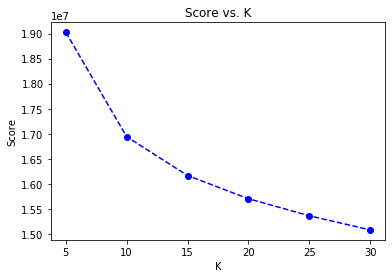

In [116]:
scores = []
centers = [5,10, 15, 20, 25, 30]

for center in centers:
    scores.append(get_score(az_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.title('Score vs. K');

Looking at the plot we would say the elbow is arround 15 clusters. Up from that the score is decreasing aprox in a linear way with a slope lower than before.

We re-fit the k-means model with 15 clusters.

In [129]:
kmeans = KMeans(n_clusters= 15)
model = kmeans.fit(az_pca)

Let´s analyze the labels predicted

In [130]:
labels_az = model.predict(az_pca)
score_az = np.abs(model.score(az_pca))
score_az

16144034.305401674

In [136]:
labels_az

array([14,  4,  0, ..., 12,  3,  7])

In [153]:
labels_az_df = pd.DataFrame(labels_az)
labels_az_df.columns = ['cluster']

Here you have the number of people in each of the clusters

In [160]:
labels_az_df.cluster.value_counts()

1     76669
9     74034
0     72450
4     67434
5     66580
6     61590
11    61443
10    60695
13    57131
3     56526
7     50564
12    39270
8     37123
2     30679
14    28601
Name: cluster, dtype: int64

#### Clustering customers database

Now we apply pca and clustering, already fitted, to the customer database

In [199]:
#We apply pca transformation, already fitted, to customers dataframe
cust_pca =  pca.transform(cust)

In [200]:
#now we get the predictions for customers
labels_cust = model.predict(cust_pca)

#### Comparing Customer Data to Demographics Data

Now that we have clustered both databases, we are going to compare the results.

Next, you can see the rate of people belonging to each customer from both databases

In [201]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
labels_cust_df = pd.DataFrame(labels_cust)
labels_cust_df.columns = ['cluster_cust']

#now we get the number of elements per cluster in customers
labels = labels_cust_df.cluster_cust.value_counts()/len(cust_pca)
labels.sort_index(inplace = True)
labels = labels_customers.to_frame()
labels.columns = ['rate_customers']

#now we analyze labels of az dataframe
labels_az_df = pd.DataFrame(labels_az)
labels_az_df.columns = ['cluster_az']
 
labels_AZ = labels_az_df.cluster_az.value_counts()/len(az_pca)
labels_AZ.sort_index(inplace = True)
labels_AZ = labels_AZ.to_frame()
labels_AZ.columns = ['rate_AZ']

labels['rate_az'] =labels_AZ['rate_AZ']

labels


,rate_customers,rate_az
0,0.070765,0.086169
1,0.185509,0.091187
2,0.004686,0.036488
3,0.012870,0.067230
4,0.010937,0.080203
5,0.029897,0.079188
6,0.312161,0.073253
7,0.076867,0.060139
8,0.010565,0.044153
9,0.035009,0.088053


We can see that in the general population clusters are balanced, all having between 3.5% to 9% of the population, while in the customers side it ranges between 0% and 31%, being clusters 6, 1 and 11 the most populated in customers (31.2%, 18.5% and 12.4%), being  overrepresented compared to the general population, as only 7%, 9% and 7% belongs to them in the general population.

Clusters 6, 1 and 11, in order of preference must be the targets for the company communication campaign

On the other hand, there are clusters misrepresented in customers database, like cluster 12 that is minimal (0.3%), compared to the general database (5%), cluster 10, with 1.9% in customers and 7.2% in general database